# Policy Gradient 

This Notebook reimplements Karpathy's basic policy gradient agent in PyTorch with GPU acceleration.



In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


In [2]:
import torch

In [12]:
env.close()

## Karpathy Basic Policy Gradient "Pong"

The following code uses a basic policy gradient method to train a 2 layer NN to play Pong.

The time needed to train 10 episodes is 13 sec with CPU.

The forward pass takes 4 seconds. So implementing this in PyTorch and using GPU will speed things up by 30%.

In [3]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time = 0

start = time.time()

while episode_number < 30000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

Episode 20 - reward total was -21.000000. running mean: -19.191718
Episode 40 - reward total was -21.000000. running mean: -19.493028
Episode 60 - reward total was -18.000000. running mean: -19.626406
Episode 80 - reward total was -21.000000. running mean: -19.838562
Episode 100 - reward total was -21.000000. running mean: -19.924114
Episode 120 - reward total was -20.000000. running mean: -19.949014
Episode 140 - reward total was -21.000000. running mean: -20.014424
Episode 160 - reward total was -19.000000. running mean: -20.058313
Episode 180 - reward total was -19.000000. running mean: -20.099129
Episode 200 - reward total was -21.000000. running mean: -20.123343
Episode 220 - reward total was -19.000000. running mean: -20.155702
Episode 240 - reward total was -20.000000. running mean: -20.099806
Episode 260 - reward total was -20.000000. running mean: -20.106200
Episode 280 - reward total was -18.000000. running mean: -20.056696
Episode 300 - reward total was -20.000000. running m

Episode 2420 - reward total was -10.000000. running mean: -8.896116
Episode 2440 - reward total was -5.000000. running mean: -8.971274
Episode 2460 - reward total was -2.000000. running mean: -8.661507
Episode 2480 - reward total was -12.000000. running mean: -8.344705
Episode 2500 - reward total was -6.000000. running mean: -8.619337
Episode 2520 - reward total was -7.000000. running mean: -8.339132
Episode 2540 - reward total was -6.000000. running mean: -8.245988
Episode 2560 - reward total was -9.000000. running mean: -8.425460
Episode 2580 - reward total was -5.000000. running mean: -8.396669
Episode 2600 - reward total was -13.000000. running mean: -8.425841
Episode 2620 - reward total was -7.000000. running mean: -8.569912
Episode 2640 - reward total was -8.000000. running mean: -8.723125
Episode 2660 - reward total was -6.000000. running mean: -8.703735
Episode 2680 - reward total was -11.000000. running mean: -8.594523
Episode 2700 - reward total was -8.000000. running mean: -

Episode 4880 - reward total was -9.000000. running mean: -1.528595
Episode 4900 - reward total was -5.000000. running mean: -1.343896
Episode 4920 - reward total was -7.000000. running mean: -0.996485
Episode 4940 - reward total was -8.000000. running mean: -1.111612
Episode 4960 - reward total was 1.000000. running mean: -1.265229
Episode 4980 - reward total was -7.000000. running mean: -1.045815
Episode 5000 - reward total was -5.000000. running mean: -1.061881
Episode 5020 - reward total was 3.000000. running mean: -1.257994
Episode 5040 - reward total was -9.000000. running mean: -1.389346
Episode 5060 - reward total was -3.000000. running mean: -1.349805
Episode 5080 - reward total was -2.000000. running mean: -1.433629
Episode 5100 - reward total was 2.000000. running mean: -1.661925
Episode 5120 - reward total was 1.000000. running mean: -1.280201
Episode 5140 - reward total was -3.000000. running mean: -1.515424
Episode 5160 - reward total was 10.000000. running mean: -1.142026

Episode 7360 - reward total was -2.000000. running mean: 1.021549
Episode 7380 - reward total was 7.000000. running mean: 0.957802
Episode 7400 - reward total was 6.000000. running mean: 0.652639
Episode 7420 - reward total was 4.000000. running mean: 0.828301
Episode 7440 - reward total was -1.000000. running mean: 0.786229
Episode 7460 - reward total was 3.000000. running mean: 0.919379
Episode 7480 - reward total was 9.000000. running mean: 0.979034
Episode 7500 - reward total was 7.000000. running mean: 1.051321
Episode 7520 - reward total was -4.000000. running mean: 1.054649
Episode 7540 - reward total was -9.000000. running mean: 1.012505
Episode 7560 - reward total was 5.000000. running mean: 0.889050
Episode 7580 - reward total was -6.000000. running mean: 0.725029
Episode 7600 - reward total was -3.000000. running mean: 0.808028
Episode 7620 - reward total was -3.000000. running mean: 0.898905
Episode 7640 - reward total was 1.000000. running mean: 0.467478
Episode 7660 - rew

Episode 9860 - reward total was 3.000000. running mean: 1.390462
Episode 9880 - reward total was -3.000000. running mean: 0.977109
Episode 9900 - reward total was -5.000000. running mean: 1.321031
Episode 9920 - reward total was 2.000000. running mean: 1.395496
Episode 9940 - reward total was -10.000000. running mean: 1.341524
Episode 9960 - reward total was 4.000000. running mean: 1.030265
Episode 9980 - reward total was 6.000000. running mean: 1.106101
Episode 10000 - reward total was 4.000000. running mean: 1.282660
Episode 10020 - reward total was -1.000000. running mean: 1.020208
Episode 10040 - reward total was 12.000000. running mean: 1.372560
Episode 10060 - reward total was 7.000000. running mean: 1.145326
Episode 10080 - reward total was -3.000000. running mean: 0.739030
Episode 10100 - reward total was -12.000000. running mean: 1.148308
Episode 10120 - reward total was 8.000000. running mean: 1.077477
Episode 10140 - reward total was -5.000000. running mean: 1.017323
Episode

Episode 12340 - reward total was 1.000000. running mean: 1.307019
Episode 12360 - reward total was 5.000000. running mean: 1.404839
Episode 12380 - reward total was 1.000000. running mean: 1.491060
Episode 12400 - reward total was 7.000000. running mean: 1.153945
Episode 12420 - reward total was -4.000000. running mean: 0.813916
Episode 12440 - reward total was -1.000000. running mean: 1.036089
Episode 12460 - reward total was 9.000000. running mean: 1.134736
Episode 12480 - reward total was 10.000000. running mean: 1.304625
Episode 12500 - reward total was 1.000000. running mean: 1.317808
Episode 12520 - reward total was 11.000000. running mean: 1.168476
Episode 12540 - reward total was -7.000000. running mean: 0.899210
Episode 12560 - reward total was 1.000000. running mean: 1.210105
Episode 12580 - reward total was -5.000000. running mean: 1.207233
Episode 12600 - reward total was 6.000000. running mean: 1.131764
Episode 12620 - reward total was 4.000000. running mean: 0.837093
Epis

Episode 14820 - reward total was 4.000000. running mean: 3.030129
Episode 14840 - reward total was 9.000000. running mean: 3.087029
Episode 14860 - reward total was 8.000000. running mean: 3.234592
Episode 14880 - reward total was -2.000000. running mean: 2.927183
Episode 14900 - reward total was 11.000000. running mean: 3.198405
Episode 14920 - reward total was 7.000000. running mean: 3.198064
Episode 14940 - reward total was -3.000000. running mean: 2.788381
Episode 14960 - reward total was 5.000000. running mean: 2.509967
Episode 14980 - reward total was 6.000000. running mean: 2.239266
Episode 15000 - reward total was -3.000000. running mean: 2.305704
Episode 15020 - reward total was 7.000000. running mean: 2.226748
Episode 15040 - reward total was -3.000000. running mean: 1.894303
Episode 15060 - reward total was 10.000000. running mean: 1.532444
Episode 15080 - reward total was 10.000000. running mean: 1.926986
Episode 15100 - reward total was 4.000000. running mean: 1.807844
Epi

Episode 17300 - reward total was 9.000000. running mean: 4.612236
Episode 17320 - reward total was 10.000000. running mean: 4.415685
Episode 17340 - reward total was 2.000000. running mean: 4.728732
Episode 17360 - reward total was 10.000000. running mean: 4.686101
Episode 17380 - reward total was -11.000000. running mean: 4.378700
Episode 17400 - reward total was 2.000000. running mean: 4.359431
Episode 17420 - reward total was 3.000000. running mean: 4.326614
Episode 17440 - reward total was 4.000000. running mean: 4.421106
Episode 17460 - reward total was 4.000000. running mean: 4.053206
Episode 17480 - reward total was 3.000000. running mean: 4.347112
Episode 17500 - reward total was 2.000000. running mean: 4.049507
Episode 17520 - reward total was 8.000000. running mean: 4.266501
Episode 17540 - reward total was -6.000000. running mean: 4.167859
Episode 17560 - reward total was 6.000000. running mean: 4.715632
Episode 17580 - reward total was 15.000000. running mean: 4.646333
Epis

Episode 19780 - reward total was 9.000000. running mean: 5.919682
Episode 19800 - reward total was 13.000000. running mean: 5.762293
Episode 19820 - reward total was 15.000000. running mean: 5.872688
Episode 19840 - reward total was 15.000000. running mean: 5.898519
Episode 19860 - reward total was 8.000000. running mean: 6.116461
Episode 19880 - reward total was 2.000000. running mean: 6.352028
Episode 19900 - reward total was 9.000000. running mean: 6.526527
Episode 19920 - reward total was 7.000000. running mean: 6.500183
Episode 19940 - reward total was -3.000000. running mean: 6.151241
Episode 19960 - reward total was 3.000000. running mean: 6.100042
Episode 19980 - reward total was 7.000000. running mean: 5.776111
Episode 20000 - reward total was -4.000000. running mean: 5.936390
Episode 20020 - reward total was -7.000000. running mean: 5.779199
Episode 20040 - reward total was 11.000000. running mean: 5.744955
Episode 20060 - reward total was 8.000000. running mean: 5.929773
Epi

Episode 22260 - reward total was 7.000000. running mean: 7.151897
Episode 22280 - reward total was -3.000000. running mean: 6.488826
Episode 22300 - reward total was 7.000000. running mean: 6.148801
Episode 22320 - reward total was 3.000000. running mean: 6.817327
Episode 22340 - reward total was 11.000000. running mean: 6.825757
Episode 22360 - reward total was 15.000000. running mean: 7.035366
Episode 22380 - reward total was 9.000000. running mean: 6.624536
Episode 22400 - reward total was 10.000000. running mean: 6.851930
Episode 22420 - reward total was 5.000000. running mean: 7.073035
Episode 22440 - reward total was 8.000000. running mean: 7.105603
Episode 22460 - reward total was -7.000000. running mean: 6.956111
Episode 22480 - reward total was 1.000000. running mean: 7.209579
Episode 22500 - reward total was 11.000000. running mean: 7.577972
Episode 22520 - reward total was 15.000000. running mean: 7.575959
Episode 22540 - reward total was 9.000000. running mean: 7.590207
Epi

Episode 24740 - reward total was 4.000000. running mean: 8.268516
Episode 24760 - reward total was 12.000000. running mean: 7.935447
Episode 24780 - reward total was 4.000000. running mean: 7.794722
Episode 24800 - reward total was 18.000000. running mean: 7.913551
Episode 24820 - reward total was -1.000000. running mean: 7.781767
Episode 24840 - reward total was 12.000000. running mean: 7.858520
Episode 24860 - reward total was 9.000000. running mean: 8.130384
Episode 24880 - reward total was 7.000000. running mean: 8.258623
Episode 24900 - reward total was 9.000000. running mean: 8.289880
Episode 24920 - reward total was 12.000000. running mean: 8.231185
Episode 24940 - reward total was 13.000000. running mean: 8.225268
Episode 24960 - reward total was 8.000000. running mean: 8.118598
Episode 24980 - reward total was 9.000000. running mean: 7.749597
Episode 25000 - reward total was 14.000000. running mean: 7.751510
Episode 25020 - reward total was 7.000000. running mean: 7.637833
Epi

Episode 27220 - reward total was 7.000000. running mean: 7.722048
Episode 27240 - reward total was 11.000000. running mean: 7.451897
Episode 27260 - reward total was 9.000000. running mean: 7.826119
Episode 27280 - reward total was 14.000000. running mean: 7.960232
Episode 27300 - reward total was 7.000000. running mean: 8.051526
Episode 27320 - reward total was 9.000000. running mean: 8.397081
Episode 27340 - reward total was -3.000000. running mean: 8.284241
Episode 27360 - reward total was 12.000000. running mean: 8.557420
Episode 27380 - reward total was 6.000000. running mean: 8.758837
Episode 27400 - reward total was 9.000000. running mean: 8.570707
Episode 27420 - reward total was 8.000000. running mean: 8.591696
Episode 27440 - reward total was 6.000000. running mean: 8.294094
Episode 27460 - reward total was 1.000000. running mean: 8.499394
Episode 27480 - reward total was 4.000000. running mean: 8.518512
Episode 27500 - reward total was 16.000000. running mean: 8.510380
Episo

Episode 29700 - reward total was 13.000000. running mean: 9.633814
Episode 29720 - reward total was 9.000000. running mean: 9.508944
Episode 29740 - reward total was 9.000000. running mean: 9.248202
Episode 29760 - reward total was 14.000000. running mean: 9.492634
Episode 29780 - reward total was 16.000000. running mean: 9.436779
Episode 29800 - reward total was 14.000000. running mean: 9.355317
Episode 29820 - reward total was 15.000000. running mean: 9.536183
Episode 29840 - reward total was 14.000000. running mean: 9.722465
Episode 29860 - reward total was 11.000000. running mean: 9.657248
Episode 29880 - reward total was 15.000000. running mean: 9.448781
Episode 29900 - reward total was 8.000000. running mean: 9.572944
Episode 29920 - reward total was 3.000000. running mean: 9.233858
Episode 29940 - reward total was 1.000000. running mean: 9.338660
Episode 29960 - reward total was 13.000000. running mean: 9.576754
Episode 29980 - reward total was 8.000000. running mean: 9.552465
E

## Display and Save Results

These training takes a long time. We need to save the following:  
(1) Reward history and Plot  
(2) Parameters at different point in training  

In [6]:
pickle.dump(epoch_reward_history, open('reward_history-pg-numpy-30000ep-lr-1e-3.p', 'wb'))

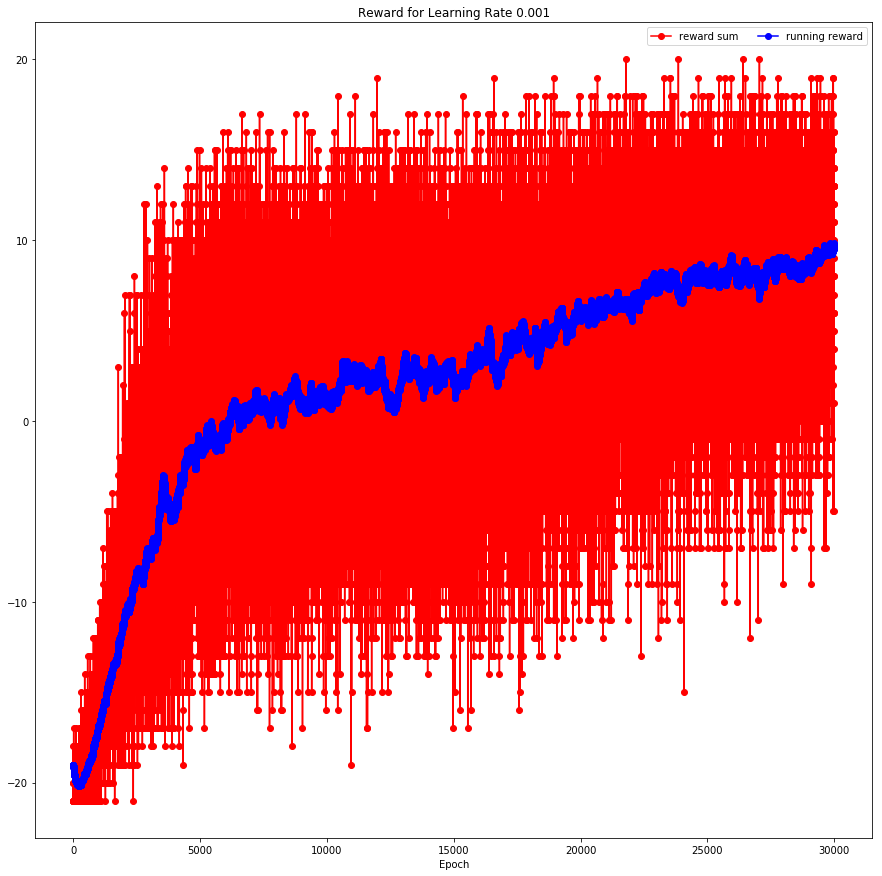

In [4]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()


## Load Parameters and Let's Play

The code below loads parameters from save.p into the pg-pong agent and renders 1 episode. The agent and the game will play til one of them reach 21 points.

In [2]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym
import time

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

model = pickle.load(open('save.p', 'rb'))

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()


def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 30000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # step the environment and get new measurements
  observation, reward, done, _ = env.step(action)
  reward_sum += reward

  if done: # an episode finished
    break
    
env.close()
print (reward_sum)

    

14.0


## Implement PyTorch 

We will now reimplement the code in PyTorch. We do a first pass converting only the forward pass to PyTorch and GPU and cut run time fro 13 seconds to 7 seconds for 10 episodes.

In [292]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym
import torch
import math

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  # Xavier initialize weights (for PyTorch)
  w1 = torch.randn(H, D).type(dtype)/math.sqrt(D)
  w2 = torch.randn(H).type(dtype)/math.sqrt(H)  
  # Duplicate weights in CPU
  model = {}
  model['W1'] = np.zeros((H,D))
  model['W2'] = np.zeros((H))

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
episode_start=True

start = time.time()

while episode_number < 1000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  x = x.reshape(-1,1)

  x_tensor = torch.from_numpy(x).type(dtype)  # convert from numpy to tensor
  if verbose:  
      print (x.shape)  
      print (x_tensor.size())  

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
    
  # aprob, h = policy_forward(x)

  h_tensor = torch.mm(w1, x_tensor)
  a_tensor = h_tensor.clamp(min=0) # ReLU nonlinearity
  logp_tensor = torch.mm(w2.view(1,-1), a_tensor)
  aprob_tensor = torch.sigmoid(logp_tensor)

  aprob = aprob_tensor.cpu().numpy()
  x = x_tensor.cpu().numpy().reshape((1,-1))
  h = h_tensor.cpu().numpy().reshape((1,-1))
    
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  if verbose:
    print (x_tensor.size())
    print (w1.size())
    print (h_tensor.size())
    print (a_tensor.size()) 
    print (w1.size())
    print (logp_tensor.size())      
    print (aprob)
    
  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1
    
    # transfer weights to CPU
    model["W1"] = w1.cpu().numpy()
    model["W2"] = w2.cpu().numpy()

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer
      
      # Transfer weights back to GPU 
      w1 = torch.from_numpy(model["W1"]).type(dtype)  
      w2 = torch.from_numpy(model["W2"]).type(dtype) 
      
    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

Episode 20 - reward total was -19.000000. running mean: -20.916350
Episode 40 - reward total was -21.000000. running mean: -20.833074
Episode 60 - reward total was -21.000000. running mean: -20.769948
Episode 80 - reward total was -20.000000. running mean: -20.691159
Episode 100 - reward total was -21.000000. running mean: -20.589595
Episode 120 - reward total was -20.000000. running mean: -20.519687
Episode 140 - reward total was -19.000000. running mean: -20.469417
Episode 160 - reward total was -20.000000. running mean: -20.456384
Episode 180 - reward total was -20.000000. running mean: -20.329737
Episode 200 - reward total was -21.000000. running mean: -20.297239
Episode 220 - reward total was -21.000000. running mean: -20.230012
Episode 240 - reward total was -20.000000. running mean: -20.224595
Episode 260 - reward total was -20.000000. running mean: -20.166056
Episode 280 - reward total was -21.000000. running mean: -20.137961
Episode 300 - reward total was -19.000000. running m

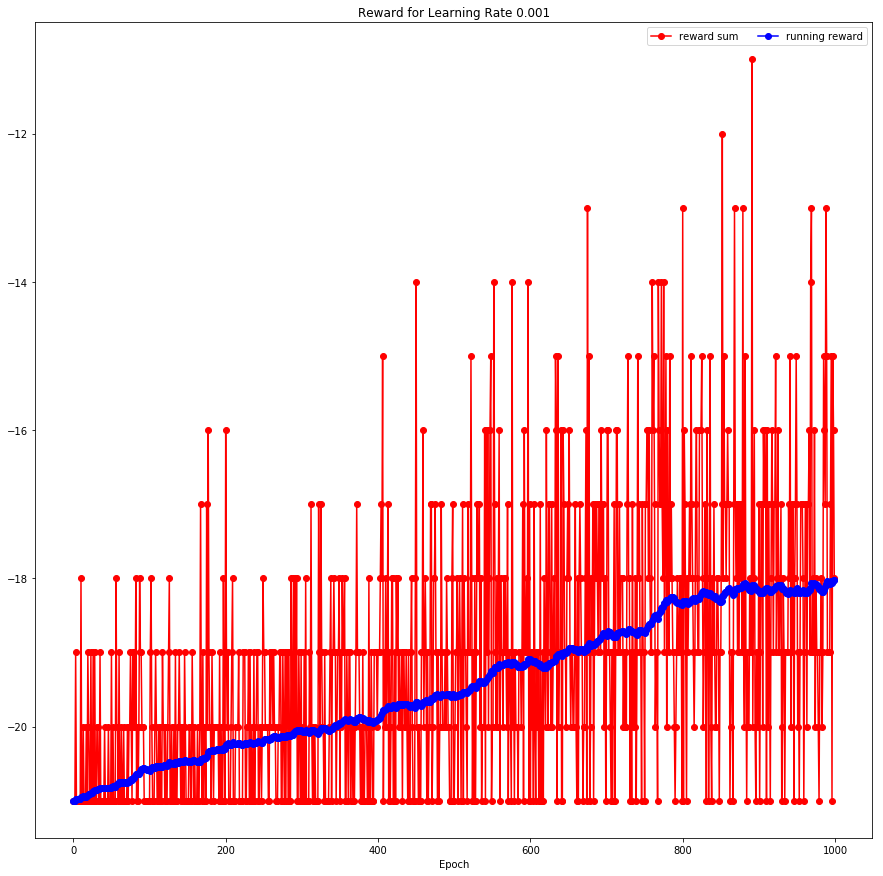

In [293]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

pickle.dump(model, open('reward_lr_1e-3_pytorch.p', 'wb'))

## Implement PyTorch 

We will now reimplement the code in PyTorch. We do a first pass converting only the forward pass to PyTorch and GPU and cut run time fro 13 seconds to 7 seconds for 10 episodes.

In [276]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym
import torch
import math

# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
# learning_rates  = [1e-5, 2.5e-5, 5e-5,1e-4,2e-4, 5e-4, 1e-3]
learning_rates  = [1e-3]

epoch_reward_history = {}
for lr in learning_rates:
    epoch_reward_history[str(lr)]=[]

lr_decay=1.0
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()


def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
verbose = False
print_every = 20

for learning_rate in learning_rates:
    print("Learning Rate is {}".format(learning_rate))
    # Xavier initialize weights (for PyTorch)
    w1 = torch.randn(H, D).type(dtype)/math.sqrt(D)
    w2 = torch.randn(1, H).type(dtype)/math.sqrt(H)

    # Set up weights in CPU
    model = {}
    model['W1'] = np.zeros((H,D))
    model['W2'] = np.zeros((H,1))

    grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
    rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory
    
    observation = env.reset()
    prev_x = None # used in computing the difference frame
    dlogps,drs = [],[]
    running_reward = None
    reward_sum = 0
    episode_number = 0
    forward_time=0
    backward_time=0
    gym_step_time=0
    episode_start = True

    start = time.time()
    
    while episode_number < 1000:
        
      if render: env.render()
      
      # preprocess the observation, set input to network to be difference image
      cur_x = prepro(observation)
      x = cur_x - prev_x if prev_x is not None else np.zeros(D)
      prev_x = cur_x
      x = x.reshape(-1,1)

      x_tensor = torch.from_numpy(x).type(dtype)  # convert from numpy to tensor
       
      # forward the policy network and sample an action from the returned probability
      t1 = time.time()
    
      # aprob, h = policy_forward(x)
      h_tensor = torch.mm(w1, x_tensor)
      a_tensor = h_tensor.clamp(min=0) # ReLU nonlinearity
      logp_tensor = torch.mm(w2, a_tensor)
      aprob_tensor = torch.sigmoid(logp_tensor)
      aprob = aprob_tensor[0,0] 

      t5 = time.time()
      if np.random.uniform() < aprob:
        action = 2
      else:
        action = 3 # roll the dice!
        
      # step the environment and get new measurements
      observation, reward, done, info = env.step(action)
      reward_sum += reward

      y = 1 if action == 2 else 0 # a "fake label"

      dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
      drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

      t6 = time.time()
      gym_step_time += t6-t5
        
      # record various intermediates (needed later for backprop)
      if episode_start:
        
        xs_tensor = x_tensor.view(1,-1).type(dtype)
        hs_tensor = h_tensor.view(1,-1).type(dtype)
        
        episode_start = False
      else:

        xs_tensor = torch.cat((xs_tensor, x_tensor.view(1,-1)),0)
        hs_tensor = torch.cat((hs_tensor, h_tensor.view(1,-1)),0)

      t2 = time.time()
      forward_time += t2-t1
        
      if done: # an episode finished
        t3 = time.time() 
        
        episode_number += 1
        episode_start = True

        # transfer weights to CPU
        model["W1"] = w1.cpu().numpy()
        model["W2"] = w2.cpu().numpy()

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = xs_tensor.cpu().numpy()   # transfer inputs to CPU
        eph = hs_tensor.cpu().numpy()   # transfer hidden stateas to CPU
      
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        dlogps,drs = [],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        
        grad = policy_backward(eph, epdlogp)
 
        for k in model: 
            grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
          for k,v in model.items():
            g = grad_buffer[k] # gradient
            rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
            model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
            grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        epoch_reward_history[str(learning_rate)].append([reward_sum, running_reward])
    
        if episode_number % print_every == 0:     
            print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

        if episode_number % 100 == 0: 
            pickle.dump(model, open('save.p', 'wb'))

        if (episode_number+1) % 1000 == 0: 
            learning_rate *= lr_decay 
        
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        
        t4 = time.time()
        backward_time += t4-t3 
    
      if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
        print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
    end = time.time()
    print ("Time to complete", end-start)
    print ("Time to forward pass", forward_time)
    print ("Time to backward pass", backward_time)
    print ("Time to step through OpenAI gym", gym_step_time)

Learning Rate is 0.001
Episode 20 - reward total was -21.000000. running mean: -20.916734
Episode 40 - reward total was -21.000000. running mean: -20.823024
Episode 60 - reward total was -21.000000. running mean: -20.819321
Episode 80 - reward total was -20.000000. running mean: -20.762845
Episode 100 - reward total was -20.000000. running mean: -20.721920
Episode 120 - reward total was -21.000000. running mean: -20.679397
Episode 140 - reward total was -21.000000. running mean: -20.693429
Episode 160 - reward total was -21.000000. running mean: -20.696540


KeyboardInterrupt: 

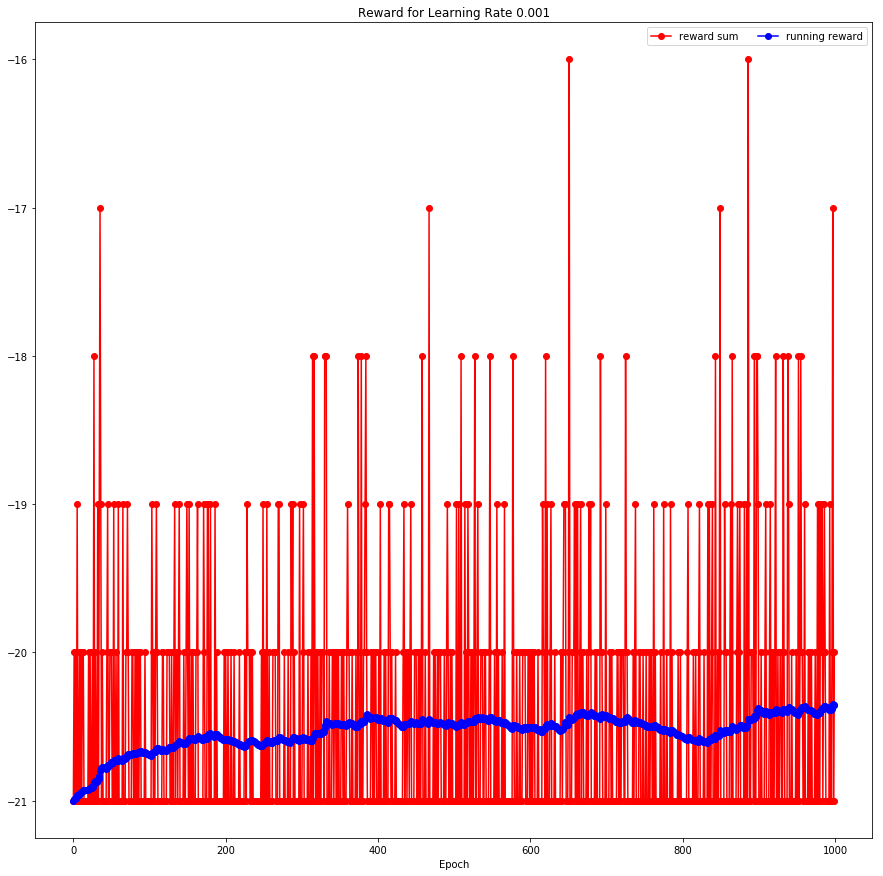

In [256]:
history = np.array(epoch_reward_history[str(lr)])

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(lr))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

## Hyperparameter Search

We tried out 7 different learning rates and run each for 1000 episodes

lr = 1e-5
best episode = -17  
running mean: -20.354719  

lr = 2.5e-5 
best episode = -16  
running mean: -20.449965  

lr = 5e-5  
best episode = -16  
running mean: -20.504167  

lr = 1e-4  
best episode = -16  
running mean: -20.421831  

lr = 2e-4 
best episode = -17  
running mean: -20.363733  

lr = 5e-4  
best episode = -17  
running mean: -20.481024  

lr = 1e-3  
best episode = -14  
running mean: -20.336540   

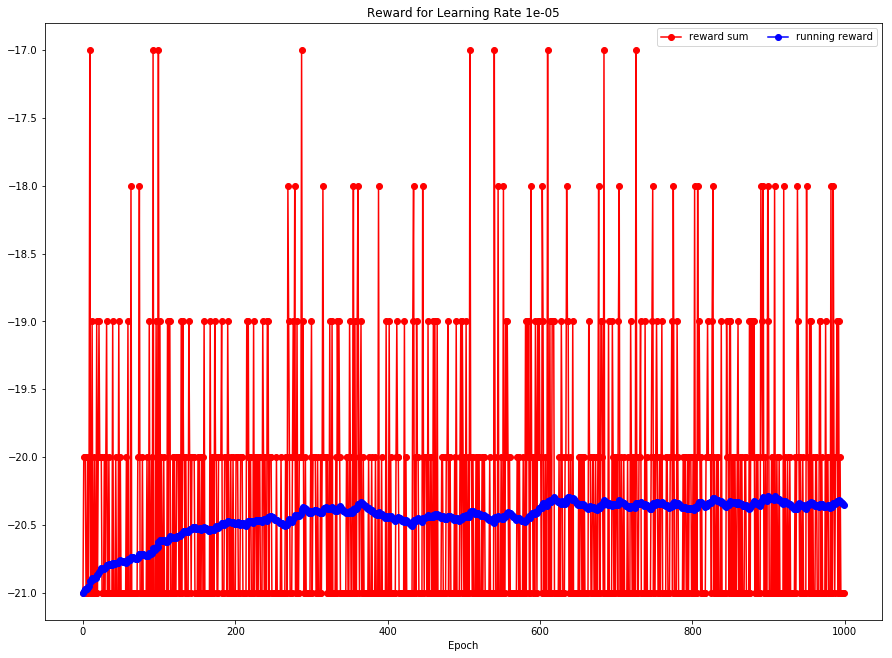

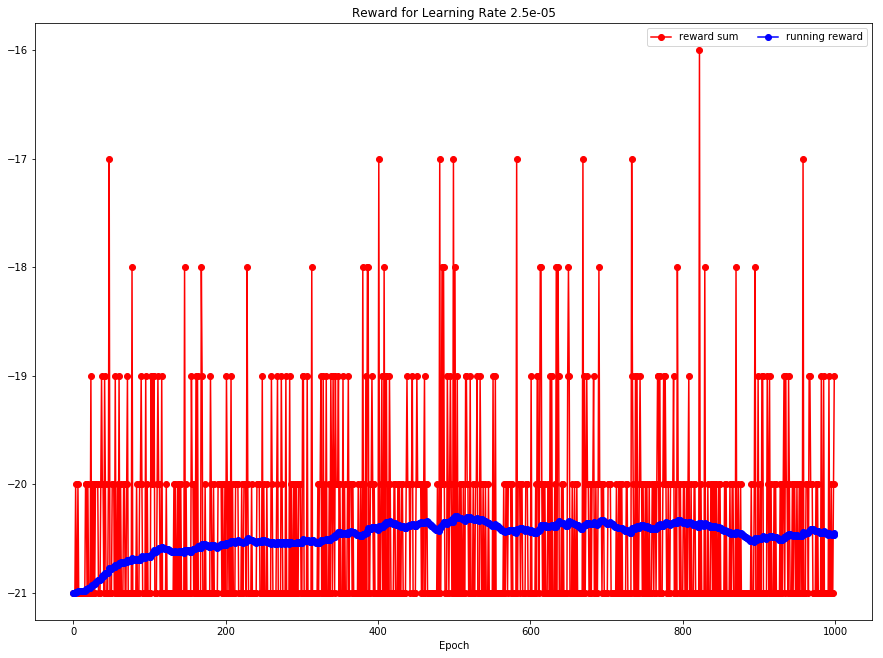

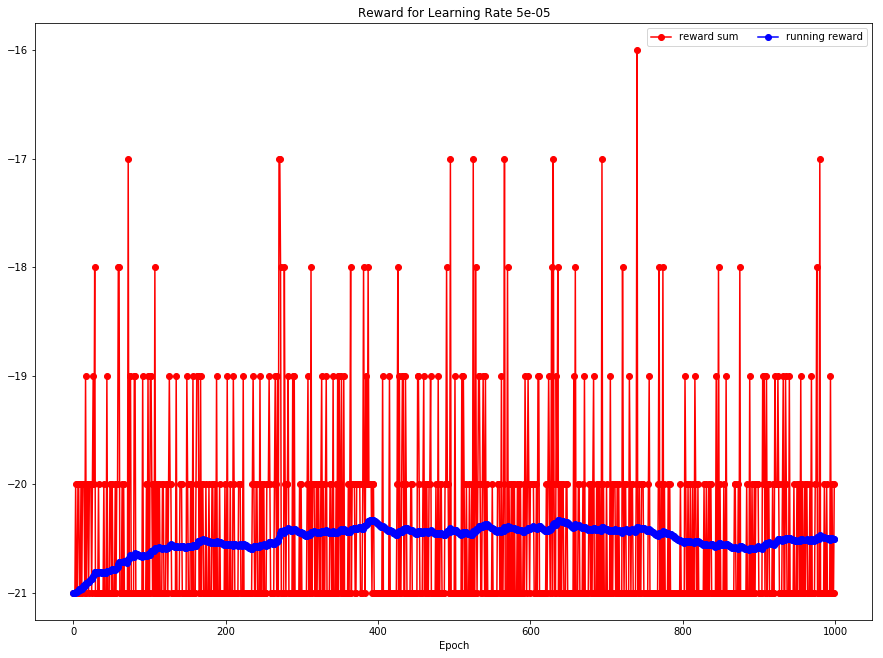

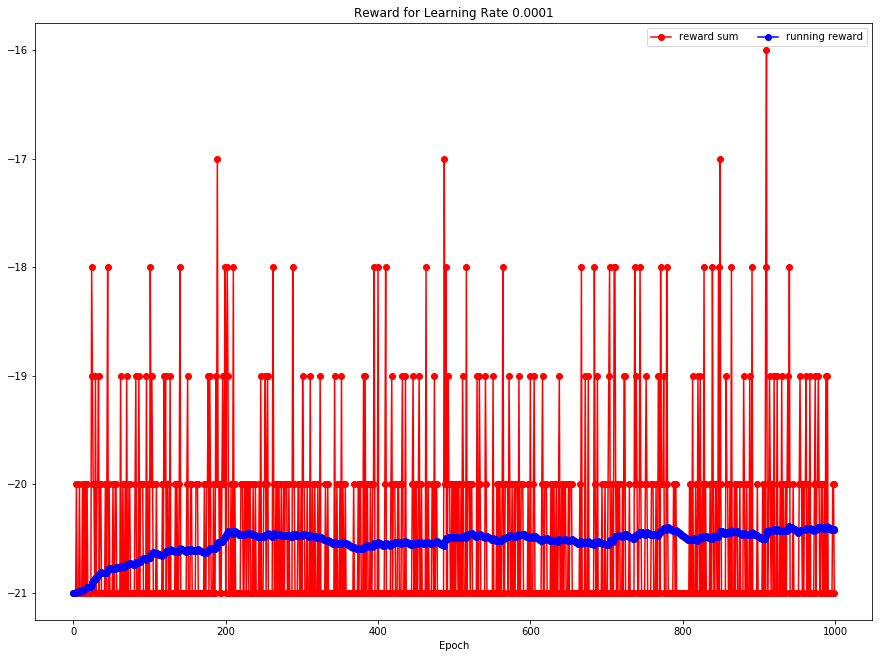

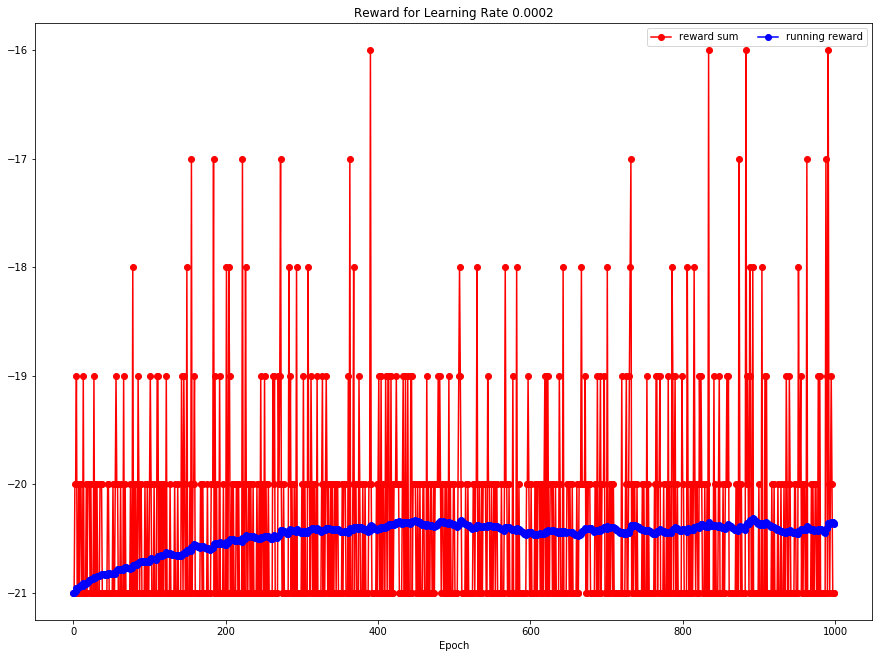

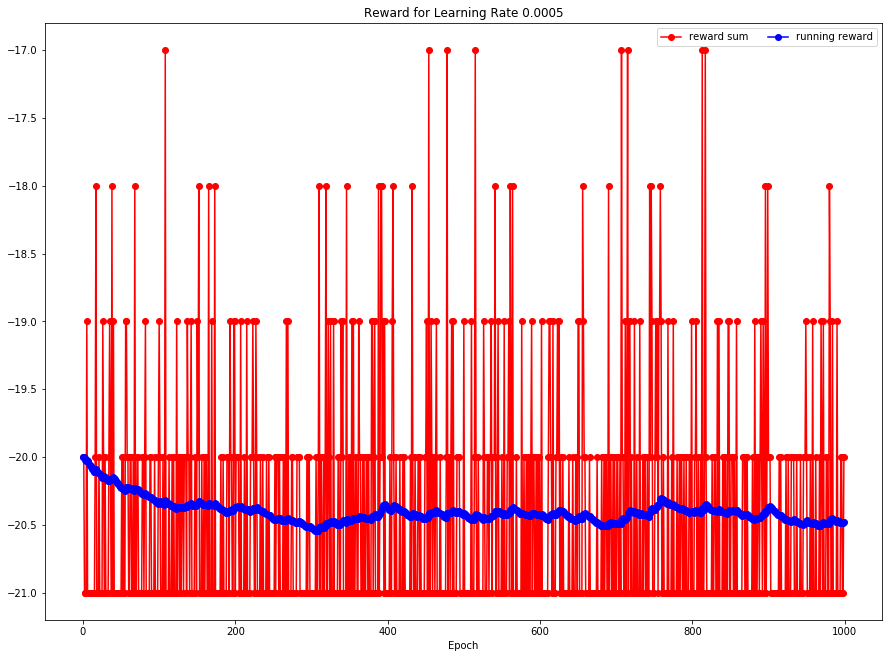

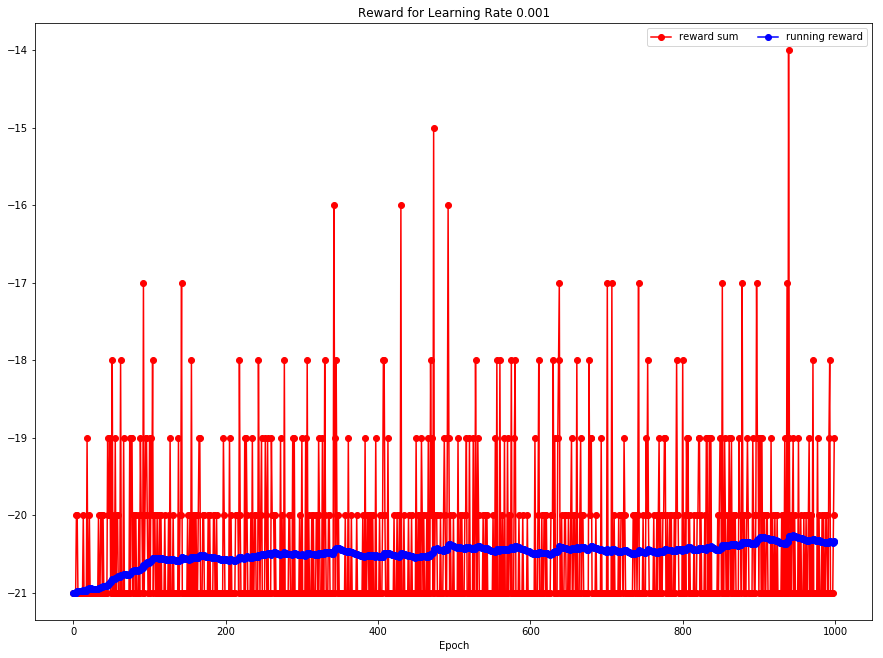

In [149]:
for lr in learning_rates:
    plt.subplot(len(learning_rates), 1, lr+1)
    history = np.array(epoch_reward_history[str(lr)])

    # Plot out the accuracies
    plt.title('Reward for Learning Rate '+str(lr))
    plt.xlabel('Epoch')
    plt.plot(history[:,0], '-ro', label="reward sum")
    plt.plot(history[:,1], '-bo', label="running reward")
    plt.legend(loc='best', ncol=4)

 
    plt.gcf().set_size_inches(15, 90)
    plt.show()

Learning rate = 5e-4

pisode 20 - reward total was -21.000000. running mean: -20.091033  
Episode 200 - reward total was -21.000000. running mean: -20.478179  
Time to complete 141.19431066513062  
Time to forward pass 31.036426782608032  
Time to backward pass 6.948922634124756  
Time to do other stuffs 21.433159112930298  

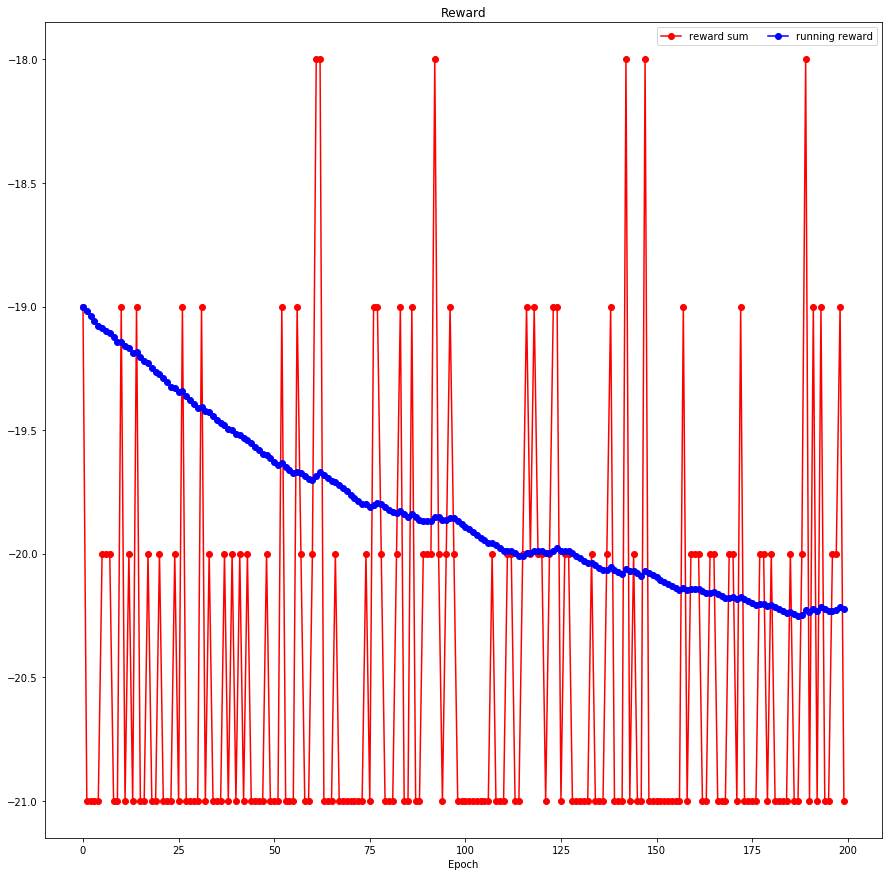

In [124]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward')
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

Learning rate = 5e-5  

Episode 20 - reward total was -21.000000. running mean: -20.936573  
Episode 200 - reward total was -20.000000. running mean: -20.499498  
Time to complete 139.78261137008667  
Time to forward pass 30.54523468017578  
Time to backward pass 6.606173992156982  
Time to do other stuffs 21.034316062927246  

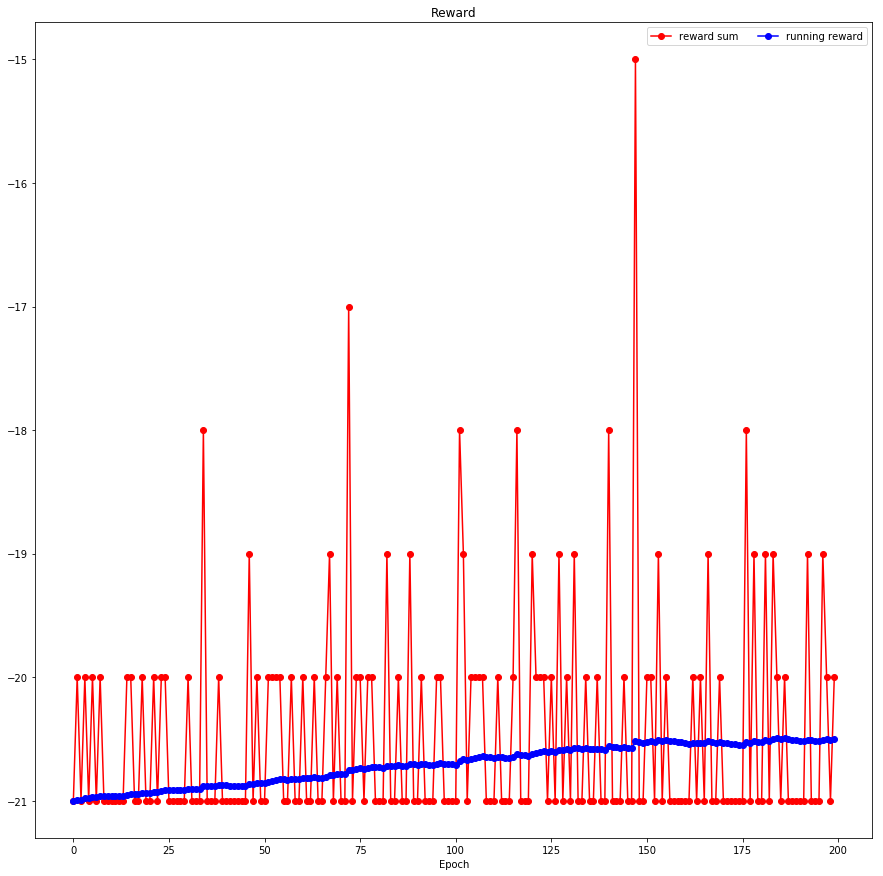

In [130]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward')
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

Learning rate = 1e-4

Episode 20 - reward total was -21.000000. running mean: -20.919417
Episode 200 - reward total was -21.000000. running mean: -20.556927

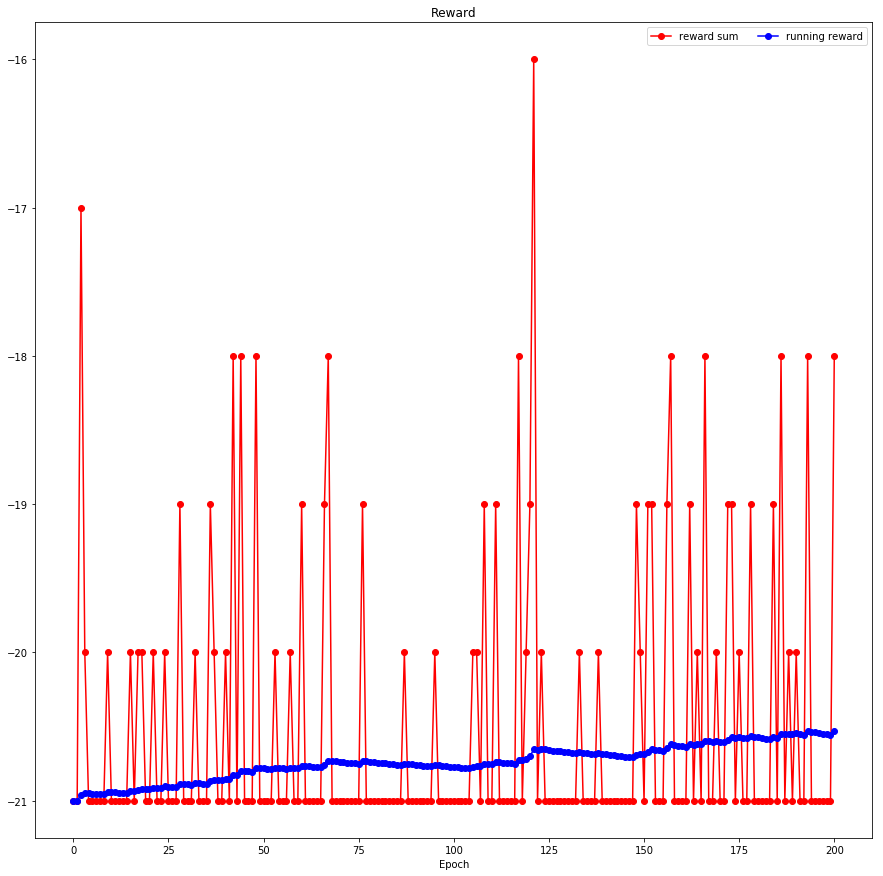

In [93]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward')
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

Learning rate = 5e-5

Not learning!!!

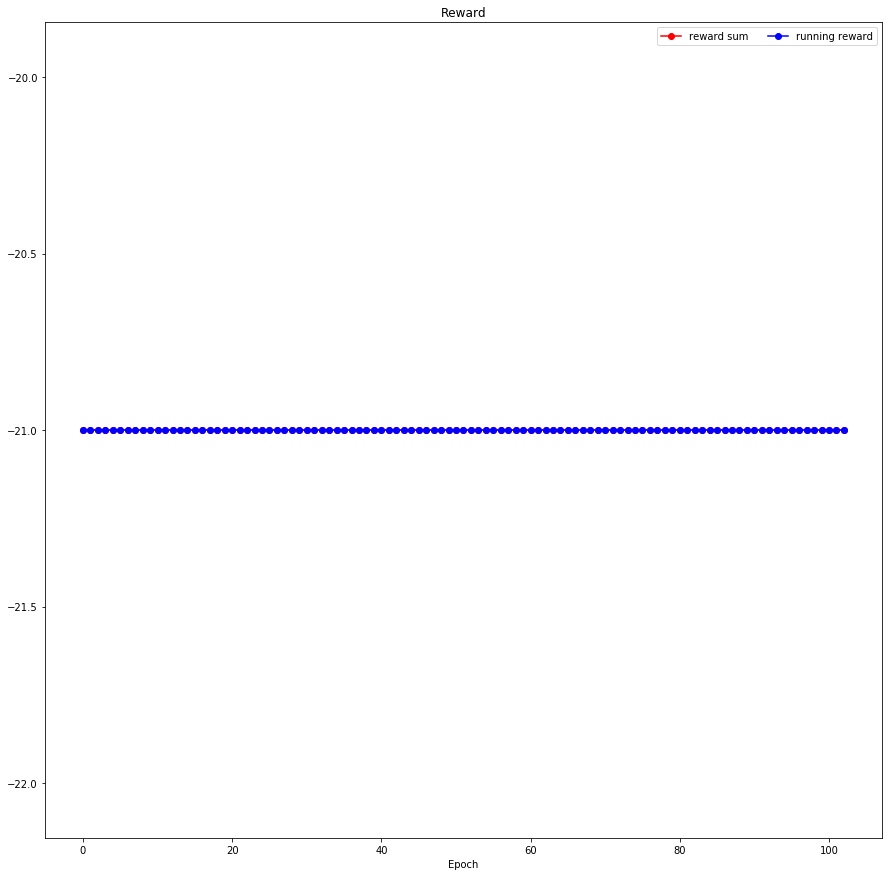

In [95]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward')
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()

In [156]:
print (x.shape)
xs = []
xs.append(x)
print (len(xs))
xs.append(x)
print (len(xs))
print (xs)

(1, 6400)
1
2
[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)]


In [200]:
print (epx.shape)
print (eph.shape)
print (epdlogp.shape)
print (epr.shape)

(1190, 6400)
(1190, 200)
(1190, 1)
(1190, 1)


In [160]:
print (x_tensor.size())

torch.Size([6400, 1])


In [164]:
print (x_tensor.size())
xs = torch.cat((x_tensor.view(1,-1), x_tensor.view(1,-1)),0)
print (xs.size())

torch.Size([6400, 1])
torch.Size([2, 6400])


In [186]:
print(I.view(-1,1))

RuntimeError: invalid argument 2: input is not contiguous at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCTensor.c:227

In [217]:
dlogps_tensor = torch.zeros(1, 1).type(dtype)
dlogps_tensor[0,0] = 5

print(dlogps_tensor)
        
drs_tensor = torch.zeros(1, 1).type(dtype)
drs_tensor [0,0] = 1
print(drs_tensor)        
        
a = torch.zeros(1, 1).type(dtype)
a[0,0] = 7
print(a)
dlogps_tensor = torch.cat((dlogps_tensor, dlogps_tensor),0) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
print(dlogps_tensor)

a[0,0] = -1 
drs_tensor = torch.cat((drs_tensor, a),0) # record reward (has to be done after we call step() to get reward for previous action)
print(drs_tensor)


 5
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 1
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 7
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]


 5
 5
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]


 1
-1
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]



In [271]:
# hyperparameters
H = 200 # number of hidden layer neurons
D = 80 * 80 # input dimensionality: 80x80 grid

model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

print (model['W1'].shape)
print (model['W2'].shape)

(200, 6400)
(200,)


In [285]:
w2 = torch.randn(H).type(dtype)/math.sqrt(H)
print (w2.shape)

a = torch.randn(200,1).type(dtype)
b = torch.mm(w2.view(1,-1), a)

torch.Size([200])
